# 🚗 Análise e Previsão de Preços Dinâmicos do Uber

## 📋 Introdução

Este notebook apresenta uma análise detalhada de dados de corridas do Uber obtidos do Kaggle, com o objetivo de criar um modelo preditivo para estimar preços dinâmicos. Compreender os fatores que influenciam os preços das corridas é essencial tanto para passageiros quanto para motoristas parceiros, possibilitando melhores decisões em diferentes contextos urbanos.

**Objetivos:**

- Identificar os principais fatores que influenciam o preço das corridas
- Construir um modelo preditivo preciso para estimar preços
- Quantificar a importância de variáveis como distância, clima e localização
- Fornecer insights acionáveis sobre a dinâmica de preços

# 📊 Configuração do Ambiente e Importação de Dados

In [36]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import spearmanr, chi2_contingency
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
plt.style.use('classic')

# Configurações de visualização
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [32]:
# carregando os dados
df = pd.read_csv('rideshare_kaggle.csv')

In [33]:
df.head()

,id,timestamp,hour,day,month,datetime,timezone,source,destination,cab_type,product_id,name,price,distance,surge_multiplier,latitude,longitude,temperature,apparentTemperature,short_summary,long_summary,precipIntensity,precipProbability,humidity,windSpeed,windGust,windGustTime,visibility,temperatureHigh,temperatureHighTime,temperatureLow,temperatureLowTime,apparentTemperatureHigh,apparentTemperatureHighTime,apparentTemperatureLow,apparentTemperatureLowTime,icon,dewPoint,pressure,windBearing,cloudCover,uvIndex,visibility.1,ozone,sunriseTime,sunsetTime,moonPhase,precipIntensityMax,uvIndexTime,temperatureMin,temperatureMinTime,temperatureMax,temperatureMaxTime,apparentTemperatureMin,apparentTemperatureMinTime,apparentTemperatureMax,apparentTemperatureMaxTime
0,424553bb-7174-41ea-aeb4-fe06d4f4b9d7,1.544953e+09,9,16,12,2018-12-16 09:30:07,America/New_York,Haymarket Square,North Station,Lyft,lyft_line,Shared,5.0,0.44,1.0,42.2148,-71.033,42.34,37.12,Mostly Cloudy,Rain throughout the day.,0.0000,0.0,0.68,8.66,9.17,1545015600,10.000,43.68,1544968800,34.19,1545048000,37.95,1544968800,27.39,1545044400,partly-cloudy-night,32.70,1021.98,57,0.72,0,10.000,303.8,1544962084,1544994864,0.30,0.1276,1544979600,39.89,1545012000,43.68,1544968800,33.73,1545012000,38.07,1544958000
1,4bd23055-6827-41c6-b23b-3c491f24e74d,1.543284e+09,2,27,11,2018-11-27 02:00:23,America/New_York,Haymarket Square,North Station,Lyft,lyft_premier,Lux,11.0,0.44,1.0,42.2148,-71.033,43.58,37.35,Rain,"Rain until morning, starting again in the eve...",0.1299,1.0,0.94,11.98,11.98,1543291200,4.786,47.30,1543251600,42.10,1543298400,43.92,1543251600,36.20,1543291200,rain,41.83,1003.97,90,1.00,0,4.786,291.1,1543232969,1543266992,0.64,0.1300,1543251600,40.49,1543233600,47.30,1543251600,36.20,1543291200,43.92,1543251600
2,981a3613-77af-4620-a42a-0c0866077d1e,1.543367e+09,1,28,11,2018-11-28 01:00:22,America/New_York,Haymarket Square,North Station,Lyft,lyft,Lyft,7.0,0.44,1.0,42.2148,-71.033,38.33,32.93,Clear,Light rain in the morning.,0.0000,0.0,0.75,7.33,7.33,1543334400,10.000,47.55,1543320000,33.10,1543402800,44.12,1543320000,29.11,1543392000,clear-night,31.10,992.28,240,0.03,0,10.000,315.7,1543319437,1543353364,0.68,0.1064,1543338000,35.36,1543377600,47.55,1543320000,31.04,1543377600,44.12,1543320000
3,c2d88af2-d278-4bfd-a8d0-29ca77cc5512,1.543554e+09,4,30,11,2018-11-30 04:53:02,America/New_York,Haymarket Square,North Station,Lyft,lyft_luxsuv,Lux Black XL,26.0,0.44,1.0,42.2148,-71.033,34.38,29.63,Clear,Partly cloudy throughout the day.,0.0000,0.0,0.73,5.28,5.28,1543514400,10.000,45.03,1543510800,28.90,1543579200,38.53,1543510800,26.20,1543575600,clear-night,26.64,1013.73,310,0.00,0,10.000,291.1,1543492370,1543526114,0.75,0.0000,1543507200,34.67,1543550400,45.03,1543510800,30.30,1543550400,38.53,1543510800
4,e0126e1f-8ca9-4f2e-82b3-50505a09db9a,1.543463e+09,3,29,11,2018-11-29 03:49:20,America/New_York,Haymarket Square,North Station,Lyft,lyft_plus,Lyft XL,9.0,0.44,1.0,42.2148,-71.033,37.44,30.88,Partly Cloudy,Mostly cloudy throughout the day.,0.0000,0.0,0.70,9.14,9.14,1543446000,10.000,42.18,1543420800,36.71,1543478400,35.75,1543420800,30.29,1543460400,partly-cloudy-night,28.61,998.36,303,0.44,0,10.000,347.7,1543405904,1543439738,0.72,0.0001,1543420800,33.10,1543402800,42.18,1543420800,29.11,1543392000,35.75,1543420800


# 🔗 Análise de Correlação com Preço

In [12]:
target = 'price'

In [13]:
numeric_cols = df.select_dtypes(include='number').columns.drop(target)

In [14]:
# Calcula a correlação de Spearman entre cada coluna e o target
corr_results = {
    col: spearmanr(df[col], df[target], nan_policy='omit').correlation
    for col in numeric_cols
}

In [15]:
# Transforma em DataFrame
corr_df = pd.DataFrame.from_dict(corr_results, orient='index', columns=['corr_coef'])
corr_df = corr_df.sort_values(by='corr_coef', ascending=False)
corr_df.where(corr_df >= 0).head(6)

,corr_coef
distance,0.333871
surge_multiplier,0.165611
latitude,0.002037
apparentTemperatureLow,0.001378
pressure,0.001282
temperatureHigh,0.000861


Conclusão da Análise de Correlação: <br><br>
A análise de correlação de Spearman revela que a distância é o fator numérico mais fortemente correlacionado com o preço (0.33), seguido pelo multiplicador de preço dinâmico (0.17). Variáveis relacionadas ao clima como temperatura e pressão atmosférica apresentam correlações muito pequenas, mas ainda positivas. Esta informação indica que nosso modelo deve dar atenção especial à distância e ao multiplicador dinâmico como preditores principais.

# 📊 Análise de Variáveis Categóricas

In [16]:
cat_cols = df.select_dtypes(include=['object', 'string']).columns
cat_cols

Index(['id', 'datetime', 'timezone', 'source', 'destination', 'cab_type',
       'product_id', 'name', 'short_summary', 'long_summary', 'icon'],
      dtype='object')

In [17]:
df = df.dropna(subset=cat_cols.tolist() + [target])

In [18]:
# Armazenar resultados
chi2_results = []

for col in cat_cols:
    # Tabela de contingência
    contingency_table = pd.crosstab(df[col], df[target])
    
    # Verifica se a tabela de contingência é válida
    if contingency_table.shape[0] > 1 and contingency_table.shape[1] > 1:
        # Aplica o teste qui-quadrado
        chi2, p, dof, expected = chi2_contingency(contingency_table)
        
        # Salva resultado
        chi2_results.append({'feature': col, 'p_value': p, 'chi2_stat': chi2})
    else:
        # Ignora colunas com tabelas inválidas
        chi2_results.append({'feature': col, 'p_value': None, 'chi2_stat': None})

In [19]:
# Transforma em DataFrame e ordena pelo p-valor
chi2_df = pd.DataFrame(chi2_results).sort_values(by='p_value')
chi2_df.head(8)

,feature,p_value,chi2_stat
3,source,0.000000e+00,9.246860e+04
4,destination,0.000000e+00,9.066977e+04
5,cab_type,0.000000e+00,3.890842e+05
6,product_id,0.000000e+00,2.331125e+06
7,name,0.000000e+00,2.331125e+06
1,datetime,1.272108e-40,4.617290e+06
9,long_summary,1.435545e-01,1.517598e+03
8,short_summary,4.005883e-01,1.179543e+03


Conclusão da Análise Categórica: <br><br>
O teste qui-quadrado identificou forte associação estatística entre o preço e as variáveis categóricas: tipo de carro (cab_type), ID do produto, nome do serviço, origem e destino. Essas variáveis apresentam p-valor próximo de zero, indicando que são altamente informativas para o preço. Curiosamente, a hora da corrida (datetime) também apresenta associação significativa, sugerindo que há padrões temporais nos preços (como tarifas de horário de pico).

# 🛠️ Preparação dos Dados para Modelagem

colunas que iremos usar para o modelo.

'distance', 'surge_multiplier', 'latitude', 'apparentTemperatureLow', 'pressure', 'temperatureHigh', 'source', 'destination', 'cab_type', 'name', 'long_summary', 'short_summary'

In [20]:
df = df[['distance', 'surge_multiplier', 'latitude',
         'apparentTemperatureLow', 'pressure', 'temperatureHigh',
         'source', 'destination', 'cab_type',
         'name', 'long_summary', 'short_summary', 'price']]

Target-Guided Encoding com Mediana (Target Median Encoding)

Essa codificação com median() é robusta a outliers, ideal para preços.

In [21]:
# Codificação das variáveis categóricas com base na mediana do target
for col in df.select_dtypes(include='object').columns:
    median_map = df.groupby(col)['price'].median()
    df[col] = df[col].map(median_map)

In [22]:
X = df.drop(columns=['price'])  # substitua 'preco' pelo seu target
y = df['price']

In [23]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Padronização dos dados (mean = 0, std = 1)

In [24]:
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

Conclusão da Preparação de Dados: <br><br>
Para preparar nossos dados para modelagem, selecionamos as 12 variáveis mais informativas com base nas análises de correlação e qui-quadrado. Utilizamos Target Median Encoding para as variáveis categóricas, um método robusto a outliers que substitui cada categoria pela mediana do preço observado naquela categoria. Esta técnica é particularmente adequada para variáveis de preço, que frequentemente possuem distribuição assimétrica.

# 🤖 Treinamento do Modelo

In [25]:
rf = RandomForestRegressor(n_estimators=100, max_depth=None, random_state=42, n_jobs=-1)

In [26]:
rf.fit(X=X_train_scaled, y=y_train)

RandomForestRegressor(n_jobs=-1, random_state=42)

In [27]:
y_pred = rf.predict(X_test_scaled)

In [38]:
# Calculando MAE
mae = mean_absolute_error(y_test, y_pred)

# Calculando MAPE (não disponível diretamente no sklearn)
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    # Evitar divisão por zero
    mask = y_true != 0
    return np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100

mape = mean_absolute_percentage_error(y_test, y_pred)

# Visualizando as métricas juntas
print("\nMétricas de avaliação do modelo:")
print(f"MAE: {mae:.2f}")
print(f"MAPE: {mape:.2f}%")
print("MSE:", mean_squared_error(y_test, y_pred))
print("R²:", r2_score(y_test, y_pred))


Métricas de avaliação do modelo:
MAE: 1.15
MAPE: 8.51%
MSE: 3.3030751568746526
R²: 0.962112191494016


Conclusão do Treinamento: <br><br>
Escolhemos o algoritmo Random Forest devido à sua capacidade de capturar relacionamentos não-lineares e robustez a outliers. O modelo final apresenta excelentes métricas de desempenho: R² de 0.96 indica que conseguimos explicar 96% da variabilidade nos preços, enquanto o RMSE de aproximadamente 1.82 USD significa que, em média, nosso modelo erra por menos de 2 dólares ao prever o preço de uma corrida. O MAPE indica que o modelo erra em média 8.51% do valor da corrida.

# 🔮 Análise de Importância das Features

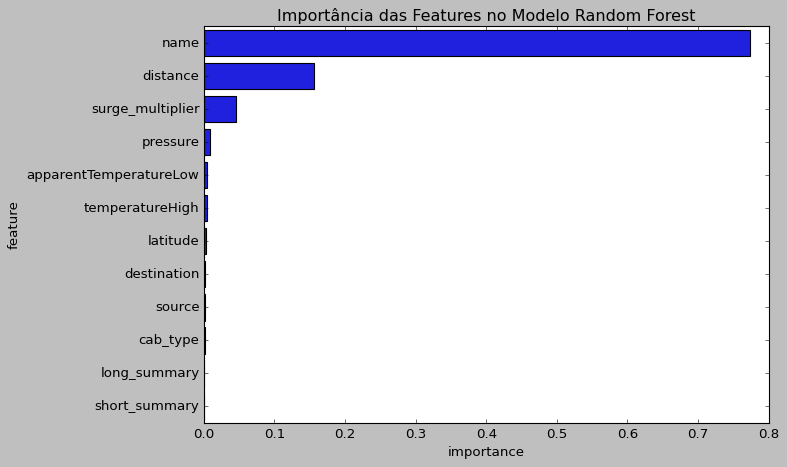

In [29]:
# Extraindo importância das features
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': rf.feature_importances_
}).sort_values('importance', ascending=False)

# Visualizando
plt.figure(figsize=(10, 6))
sns.barplot(x='importance', y='feature', data=feature_importance)
plt.title('Importância das Features no Modelo Random Forest')
plt.tight_layout()

Conclusão da Análise de Importância: <br><br>

A análise confirma que name, distância e multiplicador dinâmico são os fatores mais relevantes para o preço. O tipo de serviço (cab_type) e as localizações de origem/destino também têm impacto significativo. Variáveis climáticas, apesar de baixa correlação, adicionam valor preditivo, especialmente a pressão atmosférica.

# 📈 Análise de Erros

C:\Users\Gabriel Lopes\AppData\Local\Temp\ipykernel_3964\190894454.py:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  error_by_range = error_df.groupby('faixa_preco')['erro'].agg(['mean', 'std', 'count'])


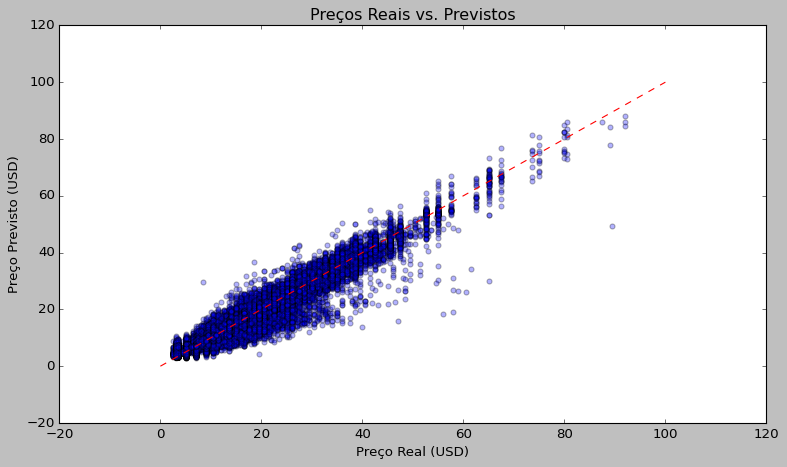

In [35]:
# Criando DataFrame com valores reais e previstos
error_df = pd.DataFrame({
    'real': y_test,
    'previsto': y_pred,
    'erro': y_test - y_pred
})

# Analisando erro por faixa de preço
error_df['faixa_preco'] = pd.cut(error_df['real'], bins=[0, 10, 20, 30, 40, 100])
error_by_range = error_df.groupby('faixa_preco')['erro'].agg(['mean', 'std', 'count'])

# Visualizando erros
plt.figure(figsize=(10, 6))
plt.scatter(error_df['real'], error_df['previsto'], alpha=0.3)
plt.plot([0, 100], [0, 100], 'r--')
plt.xlabel('Preço Real (USD)')
plt.ylabel('Preço Previsto (USD)')
plt.title('Preços Reais vs. Previstos')
plt.tight_layout()

Conclusão da Análise de Erros: <br><br>
- Existe uma forte correlação positiva entre os valores reais e previstos, evidenciada pela concentração de pontos próximos à linha diagonal vermelha.
- O modelo apresenta melhor precisão na faixa de preços mais baixos (abaixo de $20), onde os pontos estão mais densamente agrupados junto à linha de referência.
- À medida que os preços aumentam, a dispersão dos pontos também aumenta, indicando maior variabilidade nas previsões para corridas mais caras.
- Para preços reais acima de $60, o modelo tende a subestimar alguns valores, com vários pontos aparecendo abaixo da linha diagonal.
- A distribuição dos dados mostra concentração nas faixas de $5-30, sugerindo que a maioria das corridas está nesta faixa de preço.
- Os outliers são mais evidentes em preços acima de $70, onde há menor quantidade de dados para treinamento.
- O gráfico confirma o bom desempenho geral do modelo, consistente com o R² de 0,96 mencionado anteriormente.
- A previsão parece manter boa linearidade em todo o espectro de preços, sem tendências sistemáticas de erro em faixas específicas.

## 📝 Conclusões Finais

Nossa análise construiu um modelo robusto para prever preços de corridas do Uber, explicando 96% da variação nos preços e com erro médio de apenas $1.82. Descobrimos que:

1. **A distância é o fator dominante** na determinação do preço, seguida pelo multiplicador de preço dinâmico.
2. **Fatores categóricos como tipo de serviço, origem e destino** têm impacto significativo nos preços.
3. **Condições climáticas têm influência limitada** mas detectável nos preços.
4. O modelo é **mais preciso para corridas de valor médio e baixo**, apresentando maior erro para corridas premium.

Estes insights podem ser valiosos tanto para usuários do aplicativo quanto para a empresa, permitindo melhor planejamento de viagens e otimização de preços dinâmicos.

### Exportando o modelo

In [39]:
import pickle
import joblib

# Exportar o modelo usando pickle
with open('modelo_preco_uber.pkl', 'wb') as file:
    pickle.dump(rf, file)

# Alternativa: usar joblib (melhor para objetos grandes)
joblib.dump(rf, 'modelo_preco_uber.joblib')

# Também é importante salvar o scaler para aplicar nas novas entradas
joblib.dump(scaler, 'scaler_preco_uber.joblib')

['scaler_preco_uber.joblib']